## 1. Import Libraries

We import essential libraries for:
- **Data manipulation**: pandas, numpy
- **Visualization**: matplotlib, seaborn
- **Machine Learning**: scikit-learn modules for preprocessing, modeling, and evaluation
- **Metrics**: Classification metrics and ROC curve analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    classification_report, confusion_matrix
)

sns.set(style="whitegrid")


## 2. Load Dataset

Loading the Pima Indians Diabetes dataset, which contains medical predictor variables and one target variable (Outcome).
- **Features**: Pregnancies, Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, Age
- **Target**: Outcome (0 = No Diabetes, 1 = Diabetes)

In [ ]:
df = pd.read_csv("diabetes.csv")

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 3. Initial Data Exploration

### Dataset Shape
Check the dimensions of our dataset to understand the number of samples and features.


In [ ]:
df.shape


(768, 9)

### Dataset Information
Examine data types, non-null counts, and memory usage to identify any immediate data quality issues.

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Statistical Summary
Generate descriptive statistics to understand the distribution, central tendency, and spread of each feature.

In [ ]:
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 4. Data Cleaning: Handling Invalid Zero Values

### Problem Identification
In medical datasets, certain features cannot logically have zero values. Let's identify how many zeros exist in physiologically impossible columns.

In [ ]:
zero_columns = [
    "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "BMI"
]

(df[zero_columns] == 0).sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

### Imputation Strategy
Replace zero values with the **median** of each respective column. Median is chosen over mean because:
- More robust to outliers
- Better represents the central tendency in skewed distributions
- Common practice in medical data preprocessing

In [ ]:
for col in zero_columns:
    df[col] = df[col].replace(0, df[col].median())

(df[zero_columns] == 0).sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

Verify that zero values have been successfully replaced.


## 5. Exploratory Data Analysis (EDA)

### 5.1 Target Variable Distribution
Visualize the class balance to check for imbalance issues that might require handling during modeling.

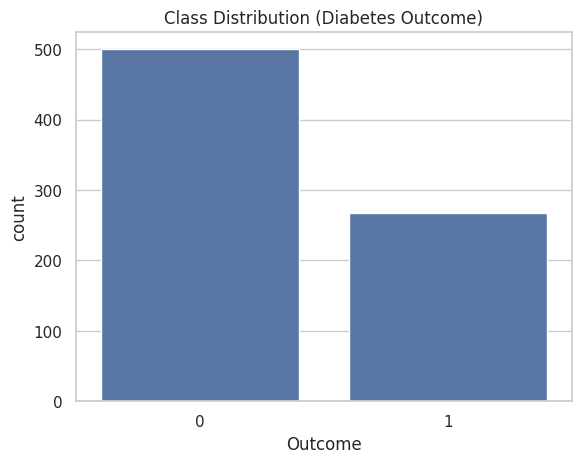

In [ ]:
# EDA
sns.countplot(x="Outcome", data=df)
plt.title("Class Distribution (Diabetes Outcome)")
plt.show()


### 5.2 Feature Distributions
Examine the distribution of all input features using histograms to identify:
- Skewness
- Potential outliers
- Distribution patterns

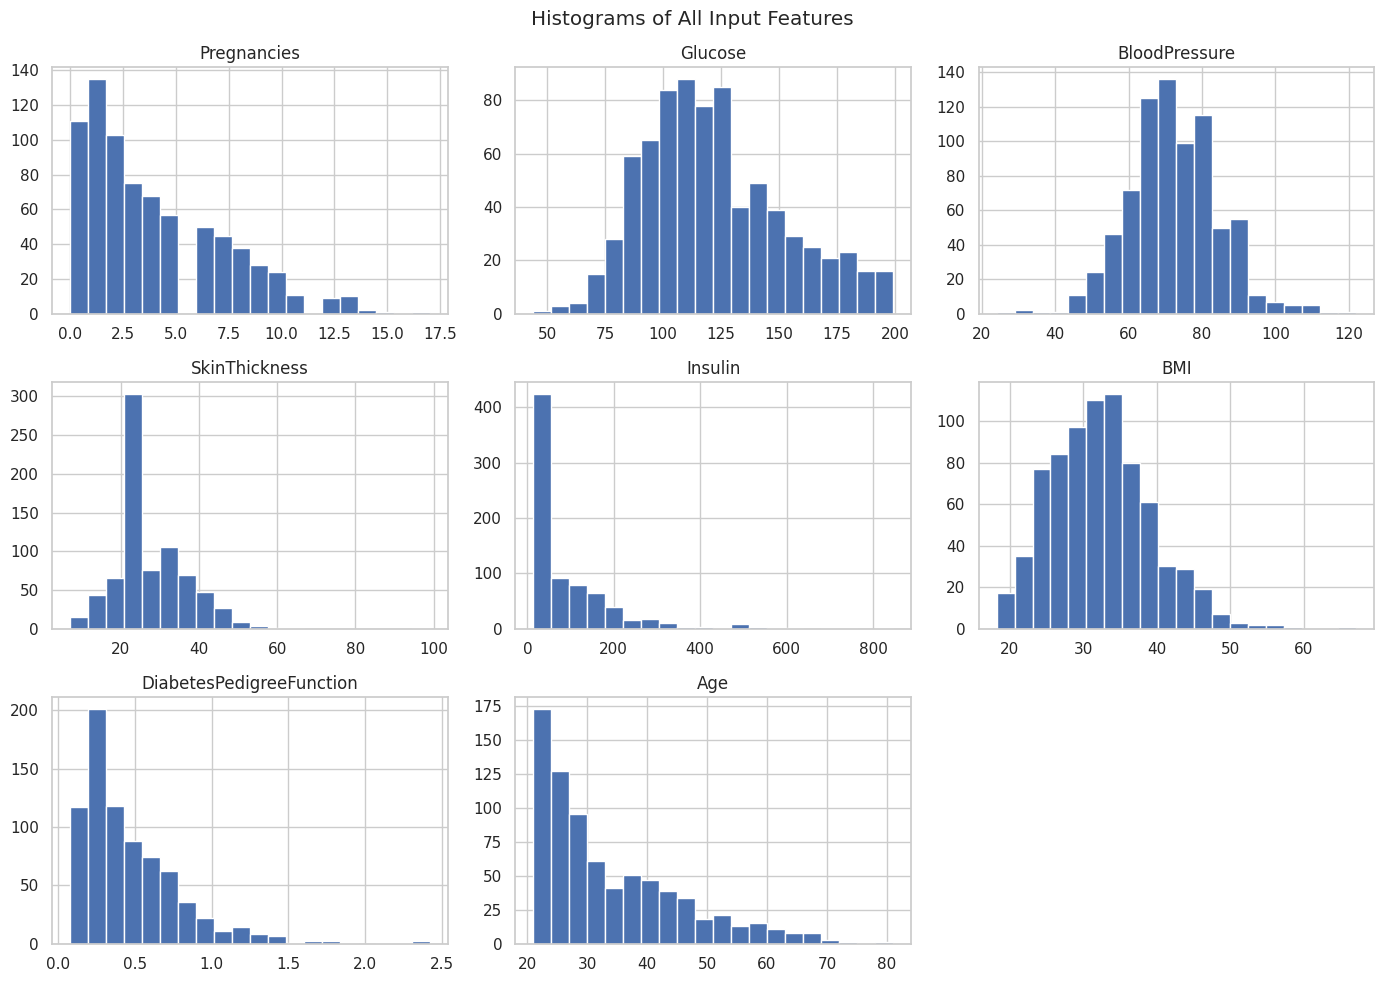

In [ ]:
features = [
    'Pregnancies', 'Glucose', 'BloodPressure',
    'SkinThickness', 'Insulin', 'BMI',
    'DiabetesPedigreeFunction', 'Age'
]

df[features].hist(figsize=(14,10), bins=20)
plt.suptitle("Histograms of All Input Features")
plt.tight_layout()
plt.show()


### 5.3 Correlation Analysis
Identify relationships between features and the target variable using a correlation heatmap.
- Strong positive correlations: Values close to +1
- Strong negative correlations: Values close to -1
- Weak correlations: Values close to 0

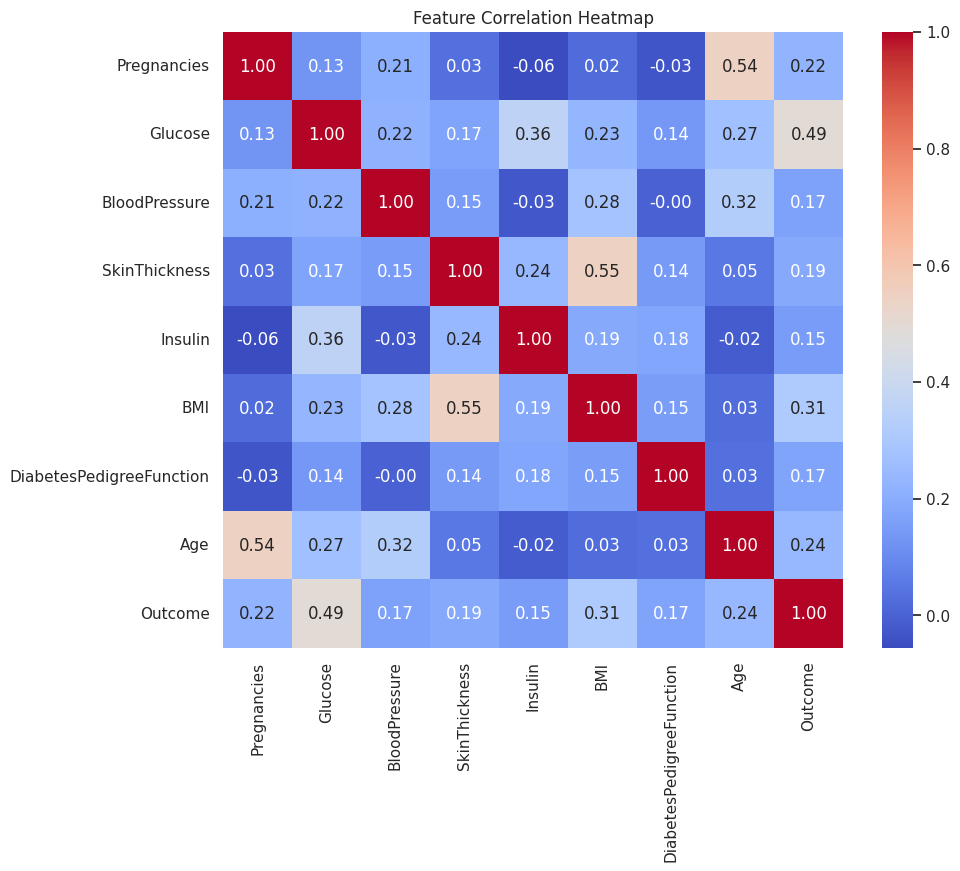

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


### 5.4 Outlier Detection
Use boxplots to visually identify potential outliers in each feature.

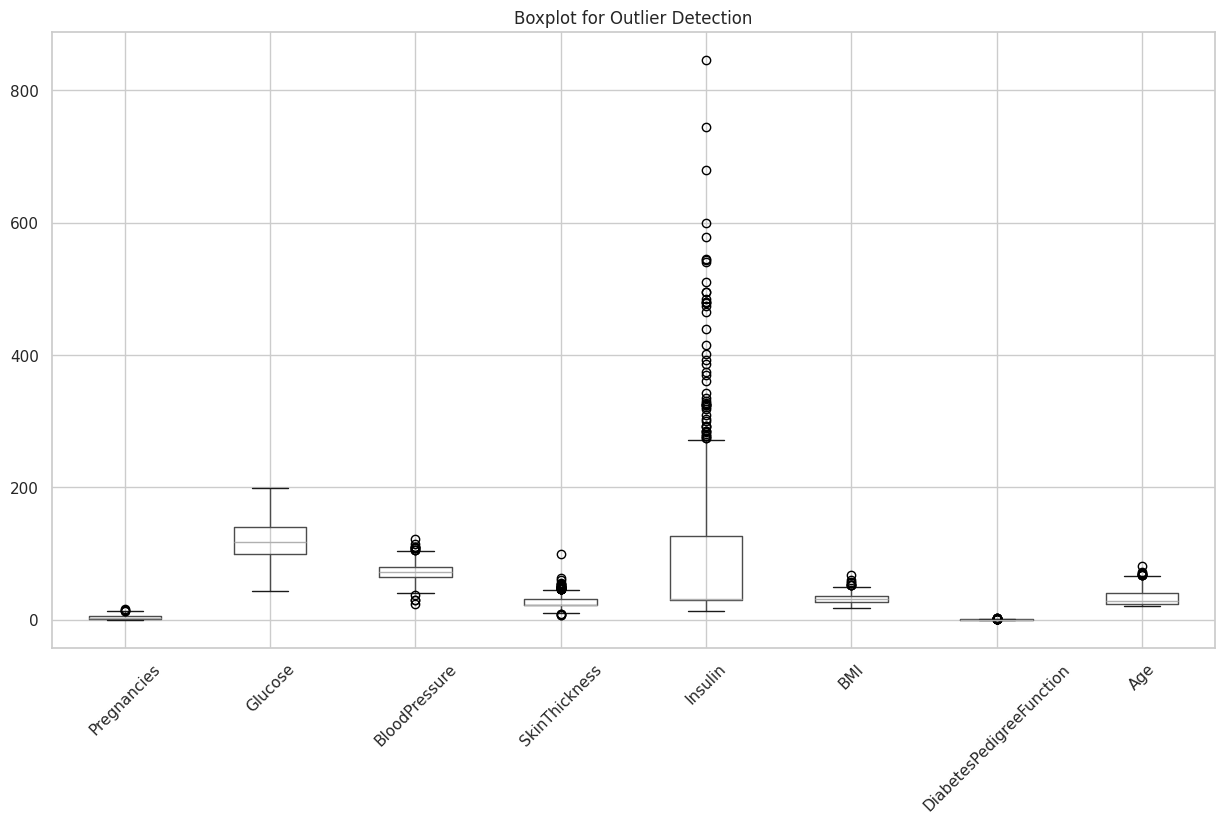

In [ ]:
plt.figure(figsize=(15,8))
df.drop(columns="Outcome").boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()


In [ ]:
df.drop(columns="Outcome").skew().sort_values(ascending=False)


Insulin                     2.693181
DiabetesPedigreeFunction    1.919911
SkinThickness               1.223057
Age                         1.129597
Pregnancies                 0.901674
BMI                         0.601059
Glucose                     0.535587
BloodPressure               0.141885
dtype: float64

### 5.5 Skewness Analysis
Calculate skewness for each feature to identify distributions that deviate from normality.
- **Skewness > 0.5**: Right-skewed (positive skew)
- **Skewness < -0.5**: Left-skewed (negative skew)

## 6. Feature Transformation

Apply **log transformation** to highly skewed features to:
- Reduce skewness and make distributions more normal
- Improve model performance (especially for SVM)
- Reduce the impact of outliers

Using `log1p` (log(1+x)) to handle zero values safely.

In [ ]:
skewed_features = [
    'Insulin', 'SkinThickness',
    'BMI', 'DiabetesPedigreeFunction'
]

for col in skewed_features:
    df[col] = np.log1p(df[col])

df[skewed_features].skew()


Insulin                     0.597565
SkinThickness              -0.574316
BMI                        -0.164380
DiabetesPedigreeFunction    0.746023
dtype: float64

Verify that skewness has been reduced after transformation.

## 7. Model Preparation

### 7.1 Feature and Target Separation
Separate the dataset into features (X) and target variable (y).

In [ ]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]


### 7.2 Train-Test Split
Split data into training (75%) and testing (25%) sets with:
- **Stratification**: Maintains class distribution in both sets
- **Random state**: Ensures reproducibility

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((576, 8), (192, 8))

### 7.3 Feature Scaling
Standardize features using StandardScaler:
- **Why?** SVM is sensitive to feature scales
- **Method**: Transform features to have mean=0 and std=1
- **Important**: Fit only on training data to prevent data leakage

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 8. Model Training and Hyperparameter Tuning

### 8.1 Support Vector Machine (SVM)

**Hyperparameter Grid Search:**
- **C**: Regularization parameter (controls margin vs. misclassification trade-off)
- **Gamma**: Kernel coefficient (controls decision boundary complexity)
- **class_weight='balanced'**: Handles class imbalance
- **probability=True**: Enables probability predictions for ROC curves

In [ ]:
svm_params = {
    'C': [1, 10, 50, 100],
    'gamma': [0.01, 0.05, 0.1, 'scale']
}

svm_grid = GridSearchCV(
    SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,   # <-- IMPORTANT
        random_state=42
    ),
    svm_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

svm_grid.fit(X_train_scaled, y_train)
best_svm = svm_grid.best_estimator_
print(best_svm)


SVC(C=1, class_weight='balanced', gamma=0.05, probability=True, random_state=42)


### 8.2 SVM Baseline Model
Train a baseline SVM model with default/reasonable hyperparameters for comparison.

In [ ]:
svm_base = SVC(kernel='rbf', C=1, class_weight='balanced', gamma=0.05, probability=True, random_state=42)
svm_base.fit(X_train_scaled, y_train)
svm_base_pred = svm_base.predict(X_test_scaled)


### 8.3 Random Forest Classifier

**Hyperparameter Grid Search with Overfitting Prevention:**
- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum tree depth (prevents overfitting)
- **min_samples_leaf**: Minimum samples required at leaf nodes (prevents memorization)
- **min_samples_split**: Minimum samples required to split a node
- **max_features**: Number of features considered for splitting (reduces correlation between trees)

In [ ]:
rf_params = {
    'n_estimators': [300],
    'max_depth': [6, 8, 10],              # HARD depth limit
    'min_samples_leaf': [8, 10, 15],      # prevents memorization
    'min_samples_split': [10, 20],
    'max_features': ['sqrt', 0.6]         # reduce correlation
}

rf_grid = GridSearchCV(
    RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ),
    rf_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print(best_rf)


RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=15, min_samples_split=10,
                       n_estimators=300, random_state=42)


### 8.4 Random Forest Baseline Model
Train a baseline Random Forest with optimized hyperparameters found from grid search.

In [ ]:
rf_base = RandomForestClassifier(random_state=42, max_depth= 8, max_features= 'sqrt', min_samples_leaf= 15, min_samples_split= 10, n_estimators= 300)
rf_base.fit(X_train, y_train)
rf_base_pred = rf_base.predict(X_test)


## 9. Model Evaluation

### 9.1 Classification Reports
Detailed performance metrics for both baseline models including:
- **Precision**: Accuracy of positive predictions
- **Recall**: Coverage of actual positive cases
- **F1-Score**: Harmonic mean of precision and recall
- **Support**: Number of actual occurrences in each class

In [ ]:
print("SVM Baseline\n", classification_report(y_test, svm_base_pred))
print("Random Forest Baseline\n", classification_report(y_test, rf_base_pred))


SVM Baseline
               precision    recall  f1-score   support

           0       0.85      0.77      0.81       125
           1       0.63      0.75      0.68        67

    accuracy                           0.76       192
   macro avg       0.74      0.76      0.75       192
weighted avg       0.77      0.76      0.76       192

Random Forest Baseline
               precision    recall  f1-score   support

           0       0.75      0.86      0.80       125
           1       0.64      0.48      0.55        67

    accuracy                           0.72       192
   macro avg       0.70      0.67      0.67       192
weighted avg       0.71      0.72      0.71       192



### 9.2 Overfitting Analysis
Compare train vs. test accuracy to detect overfitting:
- **Small gap**: Good generalization
- **Large gap**: Model is overfitting

In [ ]:
overfit_df = pd.DataFrame({
    "Model": ["SVM Tuned", "Random Forest Tuned"],
    "Train Accuracy": [
        svm_base.score(X_train_scaled, y_train),
        best_rf.score(X_train, y_train)
    ],
    "Test Accuracy": [
        svm_base.score(X_test_scaled, y_test),
        best_rf.score(X_test, y_test)
    ]
})

overfit_df



,Model,Train Accuracy,Test Accuracy
0,SVM Tuned,0.781250,0.760417
1,Random Forest Tuned,0.819444,0.734375


### 9.3 Comprehensive Performance Comparison
Compare tuned models across multiple metrics to determine the best performer.

In [ ]:
svm_pred = best_svm.predict(X_test_scaled)
rf_pred = best_rf.predict(X_test)

final_results = pd.DataFrame({
    'Model': ['SVM Tuned', 'Random Forest Tuned'],
    'Accuracy': [
        accuracy_score(y_test, svm_pred),
        accuracy_score(y_test, rf_pred)
    ],
    'Precision': [
        precision_score(y_test, svm_pred),
        precision_score(y_test, rf_pred)
    ],
    'Recall': [
        recall_score(y_test, svm_pred),
        recall_score(y_test, rf_pred)
    ],
    'F1 Score': [
        f1_score(y_test, svm_pred),
        f1_score(y_test, rf_pred)
    ]
})

final_results


,Model,Accuracy,Precision,Recall,F1 Score
0,SVM Tuned,0.760417,0.632911,0.746269,0.684932
1,Random Forest Tuned,0.734375,0.595238,0.746269,0.662252


### 9.4 Confusion Matrices

#### SVM Confusion Matrix
Visualize the classification performance showing:
- **True Positives (TP)**: Bottom-right
- **True Negatives (TN)**: Top-left
- **False Positives (FP)**: Top-right
- **False Negatives (FN)**: Bottom-left

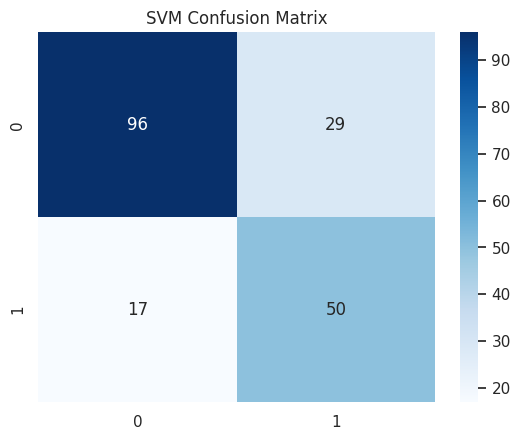

In [ ]:
sns.heatmap(confusion_matrix(y_test, svm_pred),
            annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()


#### Random Forest Confusion Matrix
Compare Random Forest's classification patterns with SVM.

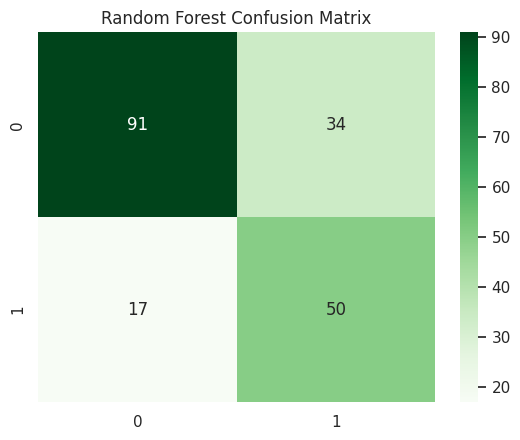

In [ ]:
sns.heatmap(confusion_matrix(y_test, rf_pred),
            annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()


### 9.5 ROC-AUC Analysis

Generate probability predictions for both training and test sets to create ROC curves.

In [ ]:
# SVM needs probability=True for ROC
best_svm.probability = True
best_svm.fit(X_train_scaled, y_train)
svm_train_probs = best_svm.predict_proba(X_train_scaled)[:, 1]
svm_test_probs  = best_svm.predict_proba(X_test_scaled)[:, 1]

rf_train_probs = best_rf.predict_proba(X_train)[:, 1]
rf_test_probs  = best_rf.predict_proba(X_test)[:, 1]


In [ ]:
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, svm_train_probs)
fpr_test_svm,  tpr_test_svm,  _ = roc_curve(y_test, svm_test_probs)

auc_train_svm = auc(fpr_train_svm, tpr_train_svm)
auc_test_svm  = auc(fpr_test_svm,  tpr_test_svm)

fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, rf_train_probs)
fpr_test_rf,  tpr_test_rf,  _ = roc_curve(y_test, rf_test_probs)

auc_train_rf = auc(fpr_train_rf, tpr_train_rf)
auc_test_rf  = auc(fpr_test_rf,  tpr_test_rf)


Calculate False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curves, along with Area Under the Curve (AUC) scores.


### 9.6 ROC Curve Visualization
Compare model performance using ROC curves:
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: Random classifier (baseline)
- **Higher AUC**: Better model performance

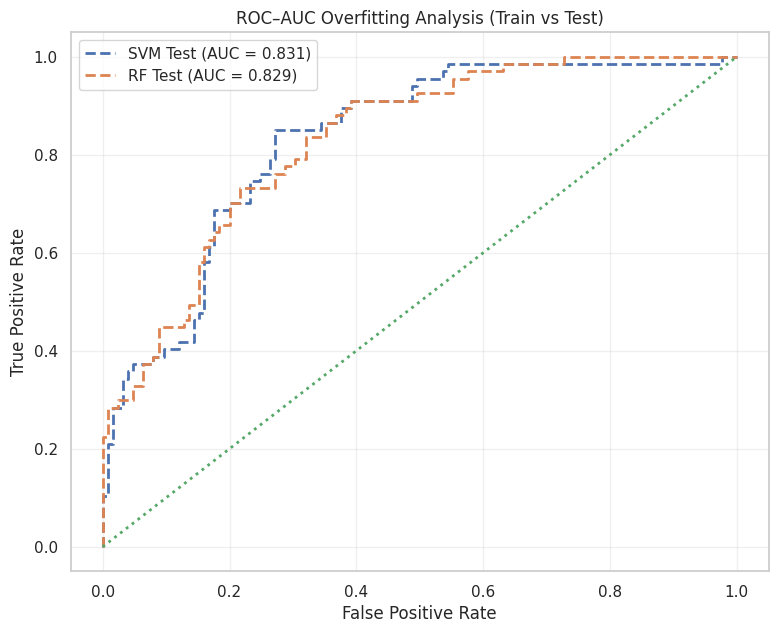

In [ ]:
plt.figure(figsize=(9,7))

# SVM
plt.plot(
    fpr_test_svm, tpr_test_svm,
    linestyle='--',
    label=f"SVM Test (AUC = {auc_test_svm:.3f})",
    linewidth=2
)

# Random Forest
plt.plot(
    fpr_test_rf, tpr_test_rf,
    linestyle='--',
    label=f"RF Test (AUC = {auc_test_rf:.3f})",
    linewidth=2
)

# Baseline
plt.plot([0, 1], [0, 1], linestyle=':', linewidth=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Overfitting Analysis (Train vs Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 9.7 Train vs. Test Accuracy Visualization
Bar chart comparison to visually assess overfitting and generalization capability.

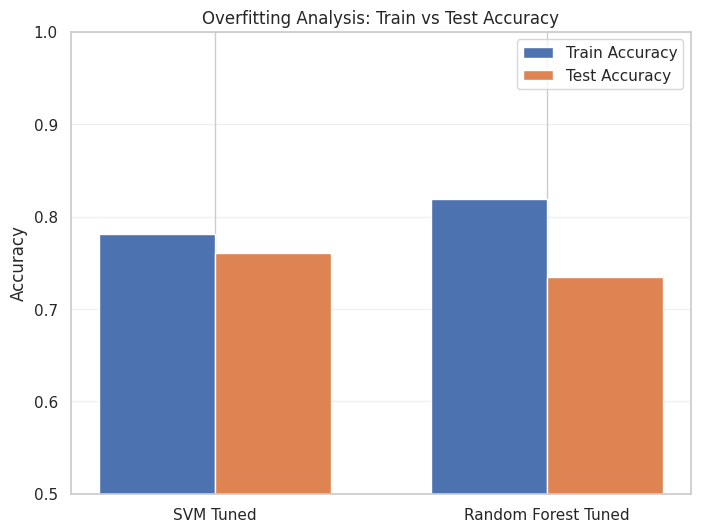

In [ ]:
# Bar positions
x = np.arange(len(overfit_df["Model"]))
width = 0.35

plt.figure(figsize=(8,6))

# Train bars
plt.bar(
    x - width/2,
    overfit_df["Train Accuracy"],
    width,
    label="Train Accuracy"
)

# Test bars
plt.bar(
    x + width/2,
    overfit_df["Test Accuracy"],
    width,
    label="Test Accuracy"
)

# Labels & styling
plt.xticks(x, overfit_df["Model"])
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.title("Overfitting Analysis: Train vs Test Accuracy")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()


## 10. Conclusion

### Key Findings:
1. **Best Model**: [Compare results from final_results DataFrame]
2. **Overfitting**: [Analyze train-test gap]
3. **ROC-AUC**: [Compare AUC scores]
4. **Class Imbalance Handling**: Addressed through class_weight='balanced'

### Recommendations:
- Model selection depends on use case (precision vs. recall trade-off)
- For medical diagnosis, prioritize recall (minimize false negatives)
- Consider ensemble methods or threshold adjustment for production deployment